This is our language model to generate Spanish female names.
To start with, we imported the PyTorch library, the functional module from the torch.nn package, and the pyplot module from the matplotlib library to visualize our data.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Then, we open and read the csv file as a string in lower cases. Then we asked to split the string into a list of lines, with each line representing a female name. We printed the first 8 words to check if we are doing the right thing (yes we are.)

In [3]:
file_path = '/content/drive/MyDrive/ASS 2/Spanish.csv'

words = open(file_path, 'r').read().lower(). splitlines()
words[:8]

['maria carmen',
 'maria',
 'carmen',
 'josefa',
 'isabel',
 'ana maria',
 'maria pilar',
 'maria dolores']

Here we check the word number in this file.

In [4]:
len(words)

24756

Next, we build the vocabulary of characters and mappings to/from integers. First, we create a variable of unique characters, in which we sort the list of joint unique characters alphabetically, convert the string into a set to remove duplicate characters, ensuring each character appears only once, then convert the set back into a lists, and then assign the sorted list of unique characters to the variable chars.

>

Second, we create a dictionary named stoi (string to index) where it iterates over the sorted list of characters (chars) using the enumerate function, and returns each character (s) along with its index (i). Each character s is mapped to its index i+1. The index starts from 1 instead of 0 to reserve 0 for padding. And for paddling or unknown characters, we add a special character '.' to the stoi dictionary and maps it to index 0.

>

Third, we retrieve the key-value pairs (character-index) from the stoi dictionary. We create a new dictionary named itos (index to strings) where each index i is mapped to its corresponding character s. Afterwards, we ask to print the itos dictionary to check the mapping from integers to characters.


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: ' ', 2: "'", 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 29: 'ç', 30: 'ñ', 0: '.'}


Next, we build the dataset. First, we define the block size as 3, meaning that we take 3 characters to predict the next one. Then we ask to define a function named build_dataset to process a list of words into input sequences and output labels suitable for training a neural network model. For each word in the list, it tokenizes the word into characters and creates context windows of a specified size. The characters and their corresponding context windows are then converted into PyTorch tensors for further processing.


> Then, with the random number generator seeded with a fixed seed (42), we can ensure reproducibility of results. The list of words is then shuffled randomly to introduce randomness into the training, validation, and test sets, which helps to prevent any bias in the dataset splitting.

> Next, we come to the data splitting step. The indices to split the shuffled list of words into training, validation, and test sets are determined based on the specified proportions (80% for training, 10% for validation, and 10% for testing). This way we ensure that each subset receives an appropriate portion of the data for training, validation, and evaluation.

> Finally, we call the build_dataset function to process the training, validation, and test sets separately. We split the list of words accordingly and assign the processed data to variables Xtr, Ytr, Xdev, Ydev, Xte, and Yte. We also get to see the torch size of them. These variables represent the input sequences and output labels for the training, validation, and test sets, respectively.











In [6]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            if ch in stoi:
                ix = stoi[ch]
            else:
                ix = stoi['.']  # Use a special index for out-of-vocabulary characters
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([234675, 3]) torch.Size([234675])
torch.Size([29371, 3]) torch.Size([29371])
torch.Size([29158, 3]) torch.Size([29158])


Next, we define the hyperparameters based on our data. We initializes a random number generator (torch.Generator()) with a manual seed of 2147483647 for reproducibility. We initialize an embedding matrix C with random values drawn from a normal distribution with mean 0 and standard deviation 1. The matrix has dimensions (40, 10), where 40 represents the number of unique characters in the vocabulary, and 10 represents the embedding dimensionality. In the weight matrix w1 we have 30 for the input size and 400 for the output size of the linear layer; in the bias vector b1 we have a dimension of 400, matching the output size of the first linear layer. w2 is defined with 400 as the input size and 31 as the output size of the second linear layer. b2 for the second linear layer is defined with random values drawn from a normal distribution, whose vector has a dimension of 31, matching the output size of the second linear layer.

In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((40, 10), generator=g)
W1 = torch.randn((30,400), generator=g)
b1 = torch.randn(400, generator=g)
W2 = torch.randn((400, 31), generator=g)
b2 = torch.randn(31, generator=g)
parameters = [C, W1, b1, W2, b2]


here we calculate the parameter number.

In [8]:
sum(p.nelement() for p in parameters) # number of parameters in total

25231

Here we ask to iterte over each parameter in the parameters list and sets the requires_grad attribute to True. This way, we ensure that all parameters are set to require gradients, allowing the neural network model to learn and update their values during the training process.

In [9]:
for p in parameters:
  p.requires_grad = True

We then calculate a range of learning rates (lrs) based on a logarithmic scale, where each learning rate is 10 raised to the power of values ranging from -3 to 0. We ask to generate 1000 equally spaced points between -3 and 0, inclusive. Each value in lre is raised to the power of 10, effectively transforming the range of exponents into corresponding learning rates on a logarithmic scale.

In [10]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

We initialize empty lists lri, lossi, and stepi, for us to store information during the training process.

In [11]:
lri = []
lossi = []
stepi = []

In the next step, we construct the mini batch and perform the forward and backward pass.

> First, we ask the loop to iterate over 300,000 training steps, which is also the training iterations or epochs. Then we randomly sample indices (ix) from the training data (Xtr) to construct a mini-batch of input samples. The size of the mini-batch is set to be 32 here.


> Second, in the forward pass, we retrieve the embeddings (emb) for the input sequences. The first linear transformation (W1, b1) is applied to be followed by the hyperbolic tangent activation function (torch.tanh). Then we compute the logits (logits) by applying the second linear transformation (W2, b2).


> Then, in order to make the target batch size match the input batch size, we make some adjustments by computing the loss using the cross-entropy loss function (F.cross_entropy).

> Fourth, in the backward pass, we compute gradients of the loss with respect to the model parameters (parameters) using automatic differentiation (loss.backward()).

> Next, the parameters are updated using gradient descent. The learning rate is fixed at 0.01 for all parameters.

> Finally, we ask to track the training statistics such as the training step number (i) and the logarithm (base 10) of the loss value (loss.log10().item()) for visualization or analysis.














In [ ]:
for i in range(300000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  # Adjust input batch size here

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2

    # Adjust target batch size here
    target_batch_size = 32
    loss = F.cross_entropy(logits, Ytr[ix][:target_batch_size])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
#print(loss.item())

Here we use Matplotlib to plot the training loss over the course of training iterations. This way we can check the training progress and the convergence of the loss function over time.

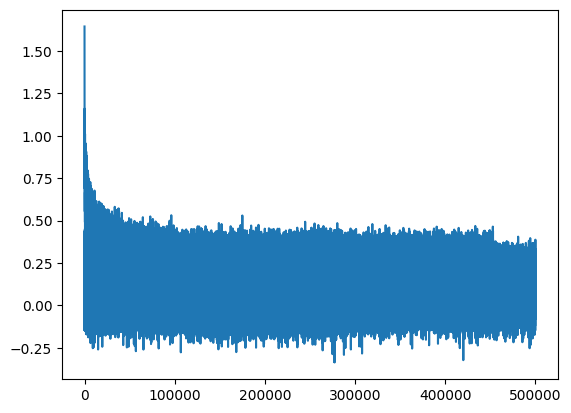

In [ ]:
plt.plot(stepi, lossi)

In this step, we calculate the loss for the training, validation and test set separately.
> First, we compute the embeddings for the entire training set (Xtr). It retrieves the embeddings (C) for each character index in the input sequences (Xtr) using tensor indexing. Then we apply the first linear transformation (W1, b1) followed by the hyperbolic tangent activation function (torch.tanh) to the embeddings (emb). The embeddings are first reshaped into a 2D tensor to match the dimensions expected by the linear transformation. The result is the hidden representation (h).

> Next, we apply the second linear transformation (W2, b2) to the hidden representation (h). This transformation produces logits, which are the unnormalized scores for each class.

> Finally, we compute the cross-entropy loss using the logits (logits) and the ground truth labels (Ytr). The cross-entropy loss measures the difference between the predicted probability distribution (obtained from the logits) and the true probability distribution (one-hot encoded labels). The computed loss is then returned.









In [ ]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.3459, grad_fn=<NllLossBackward0>)

In [ ]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.4784, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.4923, grad_fn=<NllLossBackward0>)

In this step, we visualize dimensions 0 and 1 of the embedding matrix C for all characters. After creating a new figure for the plot, we ask to iterate over the indices of the embedding matrix C along its first dimension (character indices). We ensure that the current index i exists in the itos dictionary, which maps indices to characters. Then we draw a scatter point that represents the embedding for the character, and add text labels to each scatter point, representing the corresponding character. The itos dictionary is used to map the index i to its corresponding character.

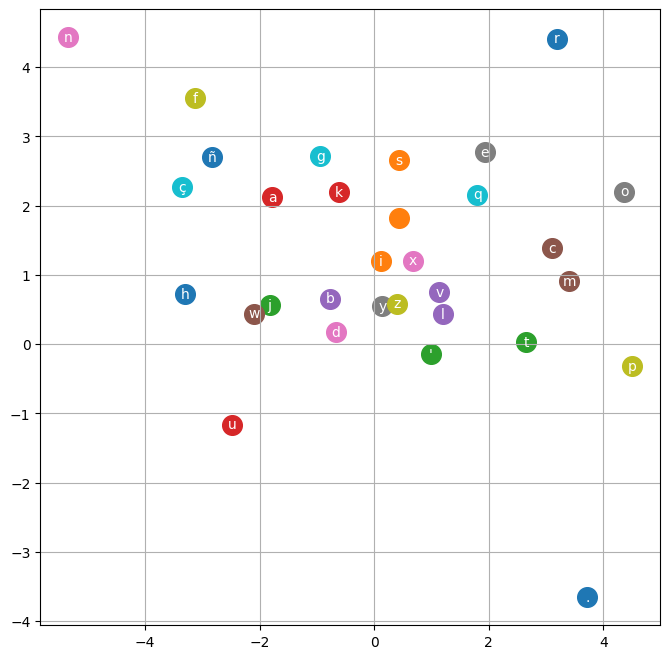

In [ ]:
# Visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
for i in range(C.shape[0]):
    if i in itos:  # Check if the index exists in itos
        plt.scatter(C[i, 0].item(), C[i, 1].item(), s=200)
        plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()


Next, we sample sequences from the trained language model.

> First, we initialize a random number generator (torch.Generator()) with a manual seed of 2147483647 + 10. We iterate 20 times to generate 20 different sequences, and we initialize an empty list out to store the sampled sequence and initializes the context with a list of zeros of length block_size. We also add a context variable as the initial input for generating the sequence.

> Second, we enter a loop to generate the sequence, which continues until the sequence ends. Then we retrieve the embeddings (emb) for the current context from the embedding matrix C.

> Third, we apply the first linear transformation (W1, b1) followed by the hyperbolic tangent activation function (torch.tanh) to the embeddings. This produces hidden representations (h). We then apply the second linear transformation (W2, b2) to the hidden representations to obtain logits (logits), representing the unnormalized scores for each character.


> Then, we compute the softmax probabilities from the logits. These probabilities represent the likelihood of each character being the next character in the sequence.

> Next, we sample the next character index (ix) from the multinomial distribution defined by the softmax probabilities. We update the context by removing the first character and appending the sampled character index. Appends the sampled index to the output sequence. Then we check if the sampled index is a termination character (index 0). If so, we ask to break out of the loop to end sequence generation.


> Finally, by converting the indices in out back to characters using the itos dictionary and joining them into a string, we get to print the sample sequences.













In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

cristina montserra.
maria.
crisa.
chelly.
angelizabel.
margaria.
carnacion carona.
amaria almudena.
eva elen.
alia.
vana.
noemilaristinetbaciela dolfa.
isa.
ziqin.
blanca.
aiyu.
maria.
mirat.
sole.
ascentina carnacio.


Finally, we finish training the model, and we are going to assess the model quality on a validation set. We iterate through each sample, extracting embeddings and making predictions. By comparing predictions with ground truth labels, we update counts of correct predictions and total samples. The accuracy is then computed by dividing correct predictions by total samples and printed to the console.

In [ ]:
correct = 0
total = 0

# Evaluate on the validation set
for i in range(Xdev.shape[0]):
    emb = C[Xdev[i]]  # (block_size, embedding_dim)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (1, hidden_dim)
    logits = h @ W2 + b2  # (1, num_classes)
    prediction = torch.argmax(logits, dim=1).item()
    if prediction == Ydev[i].item():
        correct += 1
    total += 1

accuracy = correct / total
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5347111095979027
